## Table of contents:
* [Project description: Build a simple OCR system](#first-bullet)
* [Solution pipeline](#second-bullet)
  * [1. Explore the dataset](#second-first-bullet)
  * [2. Data preprocessing and formatting](#second-second-bullet)
  * [3. Train/Val/Test dataset](#second-third-bullet)
  * [4. Build models](#second-fourth-bullet)
  * [5. Train/evaluate the model](#second-fifth-bullet)
  * [6. Text recognizer: Ready to predict new images](#second-sixth-bullet)
* [Recommendations for future work](#third-bullet)

# Project description: Build a simple OCR system <a class="anchor" id="first-bullet"></a>

In the linked `ocr.tar.gz` file there are a number of jpg files that are named as

    {counter}_{text}.jpg

where `counter` is just an arbitrary number and `text` represents the characters inside
the image, sorted left to right. What I would like you to do is:

1.  Build a simple OCR model for this data and train it
2.  Write a class that loads up a trained model and has a `predict` function which should accept an image as an input and return the OCR result as a string
3.  Show your loss curves as well as some accuracy tests with examples
4.  Write a small informal report which contains this information along with a description of the model and recommendations for improvements

# Solution pipeline <a class="anchor" id="second-bullet"></a>
Since the dataset contains focused images with the digit sequence as the main object, here we will not do text region detection. We will use the image data as the input of a multi-output classifier to classify the digits in the image. Note that the maximum length of digits in the image is 5. The base model is a CNN model with 5 convolutional layers and 5 dense output layers.


In [104]:
#if use google colab, uncomment this.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# !ls "/content/drive/My Drive/Colab Notebooks"
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/')

Mounted at /content/drive


# 1. Explore the dataset <a class="anchor" id="second-first-bullet"></a>
* Check samples images.
* Check label distribution.

In [ ]:
import tarfile
import os
import glob
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)
sns.set(rc={'figure.figsize':(20, 10)})
import warnings
warnings.filterwarnings('ignore')

from os.path import join
from skimage.io import imread
from skimage.color import rgb2gray
from collections import Counter
from numba import jit
from cv2 import resize
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.optimizers import SGD, RMSprop, Adam, Nadam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D 
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

In [ ]:
#unpack the dataset
data_file = tarfile.open("/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/ocr.tar.gz")
data_file.extractall("/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/")
data_file.close()

In [94]:
#get the data file list
@jit
def get_img_list(data_path):
    return os.listdir(data_path)
data_path = "/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/ocr_dataset/"
img_files = get_img_list(data_path)
print(len(img_files))
img_files[:5]

33402


['32067_46.jpg',
 '32415_527.jpg',
 '32347_2.jpg',
 '31926_103.jpg',
 '31248_47.jpg']

In [ ]:
@jit
def visualize(data_path, img_files, n_cols = 5, n_rows=2):
    plt.figure(figsize = (2*n_cols,2*n_rows))
    for n,i in enumerate(np.random.choice(range(len(img_files)), size = n_cols*n_rows)):
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(imread(join(data_path, img_files[i]))) #or .resize(32,32)
        plt.title(img_files[i].split('.')[0].split('_')[-1])
    plt.show()

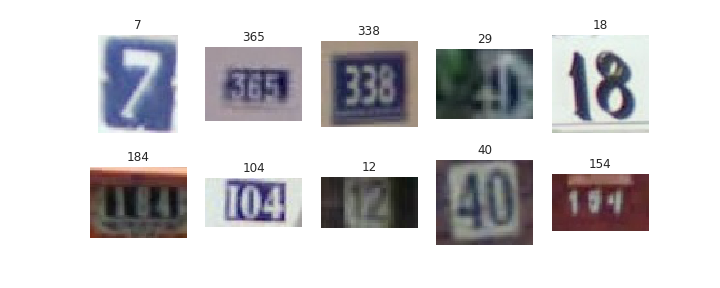

In [96]:
#Visualize sample images
visualize(data_path, img_files, n_cols = 5, n_rows=2)

In [97]:
#Creat ground truth dataframe
df = []
for i in range(len(img_files)):
    df.append([img_files[i], img_files[i].split('.')[0].split('_')[-1]])
df = pd.DataFrame(df)
df.columns = ['img_name', 'label']
df.head()
print('Numbers of digits:', set([len(ele) for ele in df['label']]))
print('Maximum number of digits:', max(set([len(ele) for ele in df['label']])))

Numbers of digits: {1, 2, 3, 4, 5}
Maximum number of digits: 5


Text(0.5, 1.0, 'Distribution of the number of digits appeared in the dataset')

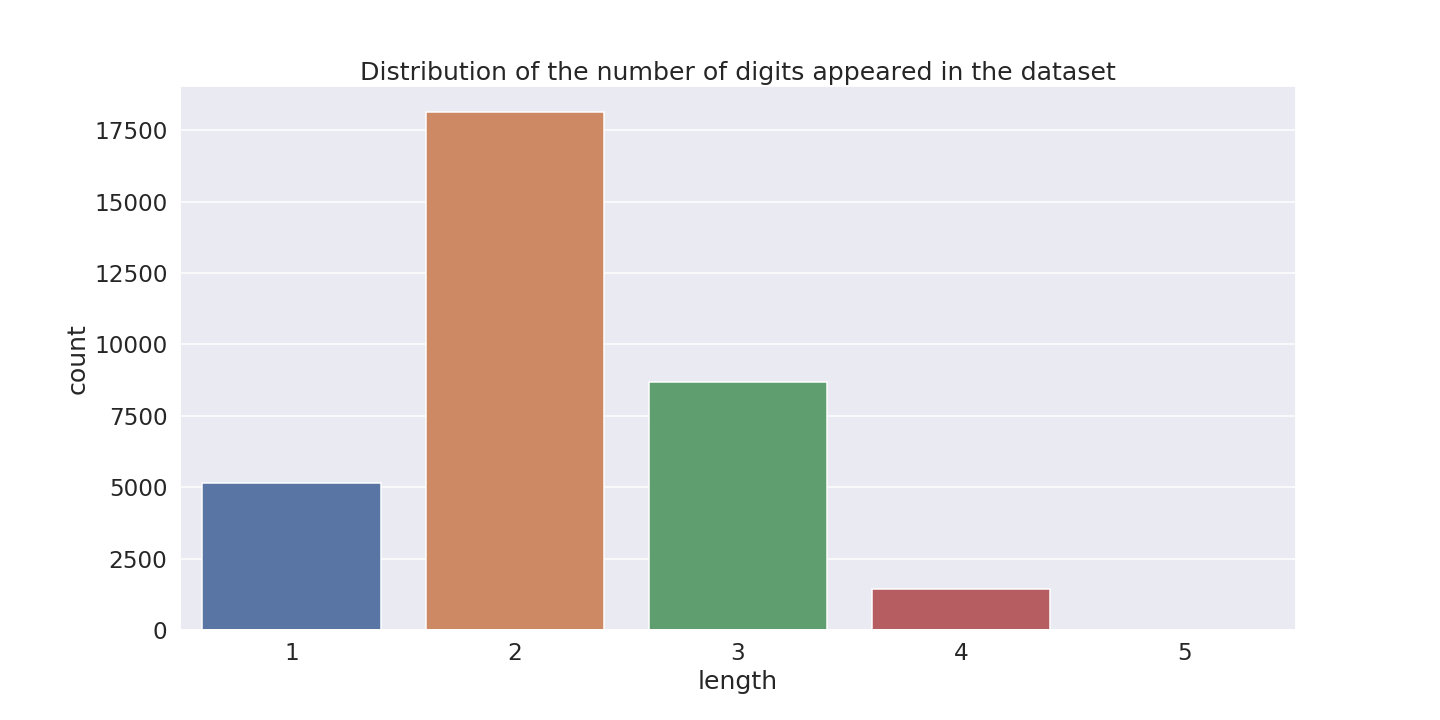

In [98]:
#Plot number of digits in the dataset
sns.set_context("talk", font_scale=1.4)
number_counter = dict(Counter([len(ele) for ele in df['label']]))
number_digits = pd.DataFrame.from_dict(number_counter, orient='index')
number_digits.columns = ['count']
sns.barplot(x ='index', y='count', 
            data=number_digits.reset_index());
plt.xlabel('length')
plt.title('Distribution of the number of digits appeared in the dataset')

In [99]:
#Create the counters for 10 digits.
digit_counter = dict({str(i):0 for i in range(10)})
print('Initial digit counter is:',digit_counter)
for i in range(len(df['label'])):
    temp_counter = dict(Counter(df['label'][i]))
    for key in temp_counter:
      temp = digit_counter[key]
      digit_counter[key] = temp + temp_counter[key]    
print('Final digit counter is:', digit_counter)


Initial digit counter is: {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0, '7': 0, '8': 0, '9': 0}
Final digit counter is: {'0': 4948, '1': 13861, '2': 10586, '3': 8496, '4': 7457, '5': 6880, '6': 5728, '7': 5595, '8': 5044, '9': 4659}


Text(0.5, 1.0, 'Distribution of the count of the digits appeared in the dataset')

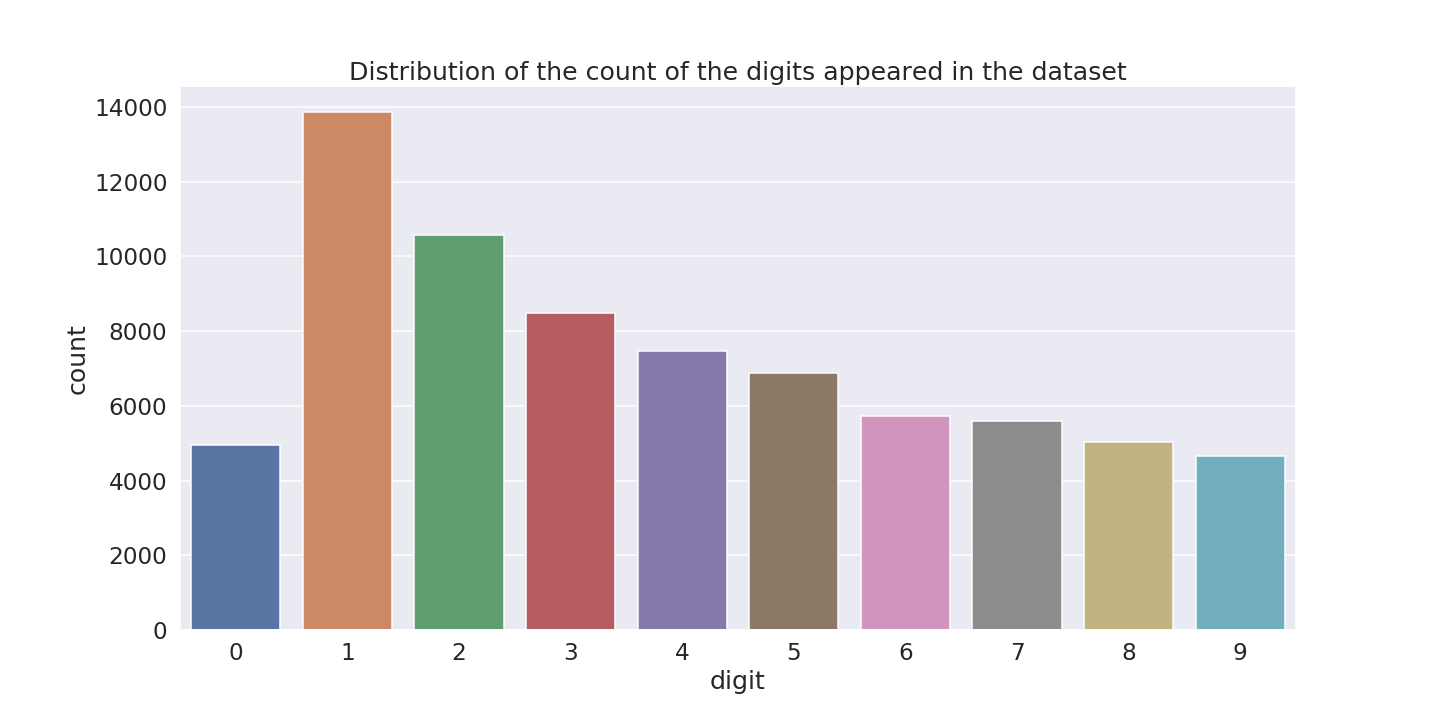

In [100]:
#Plot digit distribution in the dataset
sns.set_context("talk", font_scale=1.4)
digit_count = pd.DataFrame.from_dict(digit_counter, orient='index')
digit_count.columns = ['count']
sns.barplot(x ='index', y='count', 
            data=digit_count.reset_index());
plt.xlabel('digit')
plt.title('Distribution of the count of the digits appeared in the dataset')

# 2. Data preprocessing and formatting <a class="anchor" id="second-second-bullet"></a>
Please note that image data reading and preprocessing is much faster using local machine than using colab and Google Drive. Therefore, this section can be done at local machine. And remember to save the processed data.

In [101]:
#label preprocessing: padding the labels with a fixed length of 5
df[['0','1','2','3','4']] = df['label'].apply(lambda x: pd.Series([10]*(5-len(x))+[int(i) for i in x])) #list(map(lambda x: [10]*(5-len(x))+[int(i) for i in x], df['label']))
df.head()
# df.iloc[0]

,img_name,label,0,1,2,3,4
0,32067_46.jpg,46,10,10,10,4,6
1,32415_527.jpg,527,10,10,5,2,7
2,32347_2.jpg,2,10,10,10,10,2
3,31926_103.jpg,103,10,10,1,0,3
4,31248_47.jpg,47,10,10,10,4,7


In [ ]:
#load image data and resize images
@jit()
def load_image_data(data_path, data):
    images, labels = [], []
    n = len(data)    
    for i in range(n):
        if i%1000 == 0:
            print(i, data.iloc[i,0])        
        img = imread(join(data_path, data.iloc[i,0]))
        img = rgb2gray(img)
        img = resize(img, (32,32))
        images.append(img)
        labels.append(data.iloc[i,2:].as_matrix().astype('int16'))
    return images, labels
all_images, all_labels = load_image_data(data_path, df)

In [ ]:
with open('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/all_images.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(all_images, filehandle)

with open('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/all_labels.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(all_labels, filehandle)


# 3. Train/Val/Test dataset <a class="anchor" id="second-third-bullet"></a>
Prepare the datasets for training/validation/testing. The ratio we used is 4:1:1 for train vs. val vs. test.

In [ ]:
#Load preprocessed data
with open('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/all_images.data', 'rb') as filehandle:
    # read the data as binary data stream
    all_images = pickle.load(filehandle)

with open('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/all_labels.data', 'rb') as filehandle:
    # read the data as binary data stream
    all_labels = pickle.load(filehandle)

Label:  [10 10 10  3  4]


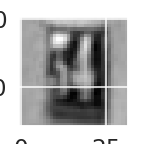

In [106]:
print('Label: ', all_labels[10])
plt.figure(figsize=(2,2))
plt.imshow(all_images[10], cmap=plt.cm.gray);

In [107]:
labels = pd.DataFrame(list(map(np.ravel, all_labels)))
labels.head()

,0,1,2,3,4
0,10,10,4,5,1
1,10,10,2,3,2
2,10,10,2,1,3
3,10,10,10,3,3
4,10,10,10,10,4


In [108]:
images = pd.DataFrame(list(map(np.ravel, all_images)))
images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.100255,0.123387,0.147340,0.171233,0.192667,0.213137,0.260823,0.305369,0.331967,0.357991,0.380958,0.406428,0.434744,0.458213,0.500540,0.540546,0.564052,0.589933,0.618011,0.645170,0.660417,0.677879,0.678906,0.676577,0.669199,...,0.636762,0.638385,0.642521,0.640884,0.643168,0.643168,0.642371,0.646875,0.649632,0.652150,0.656653,0.654111,0.649970,0.651931,0.650189,0.650189,0.652150,0.654111,0.655102,0.652390,0.649039,0.649022,0.649481,0.648771,0.648189
1,0.318766,0.309125,0.297029,0.317431,0.303592,0.321157,0.328718,0.327649,0.318123,0.329611,0.339800,0.349617,0.335144,0.356518,0.349262,0.354057,0.393205,0.441598,0.425519,0.421524,0.434539,0.427478,0.454330,0.474969,0.474596,...,0.578892,0.530101,0.492226,0.466969,0.444972,0.412702,0.424398,0.530471,0.603375,0.621490,0.639413,0.608160,0.486724,0.314301,0.389981,0.419393,0.439181,0.480489,0.485002,0.483850,0.496056,0.540271,0.568560,0.572045,0.571373
2,0.528148,0.528085,0.541553,0.558999,0.568055,0.573797,0.564862,0.549071,0.550250,0.553911,0.567987,0.573458,0.583643,0.595163,0.597731,0.604220,0.611181,0.613142,0.614963,0.610411,0.594624,0.596026,0.588918,0.593419,0.575340,...,0.579596,0.588111,0.583178,0.584107,0.588794,0.579550,0.589920,0.614927,0.617175,0.602924,0.605713,0.607627,0.604913,0.591433,0.600136,0.587638,0.594850,0.595859,0.590271,0.597925,0.592127,0.605607,0.612225,0.616888,0.621343
3,0.179459,0.158400,0.143421,0.151170,0.158771,0.171911,0.169574,0.185705,0.212587,0.227543,0.244321,0.276338,0.280234,0.297648,0.296585,0.258120,0.260378,0.293469,0.291270,0.270988,0.240108,0.243554,0.241147,0.222721,0.179451,...,0.154447,0.147331,0.140219,0.140177,0.144137,0.155169,0.167256,0.180532,0.173247,0.161584,0.162599,0.163839,0.154392,0.149636,0.136547,0.141771,0.138437,0.114992,0.098433,0.090989,0.100048,0.107156,0.112180,0.111204,0.098653
4,0.302282,0.305159,0.334361,0.355945,0.345181,0.336841,0.336802,0.323909,0.315567,0.341189,0.357168,0.357168,0.353921,0.355706,0.352104,0.344217,0.343064,0.342814,0.339449,0.350969,0.351144,0.353174,0.359691,0.354237,0.349085,...,0.325985,0.327248,0.352319,0.365635,0.370733,0.362823,0.364385,0.365210,0.358724,0.356182,0.359502,0.361781,0.365757,0.357160,0.357160,0.360653,0.361295,0.364107,0.365271,0.355875,0.340430,0.328148,0.319730,0.307659,0.270588


In [109]:
@jit
def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])    
    for i in range(n):
        data_cat[:, i] = to_categorical(data[:, i], num_classes=11)        
    return data_cat
#test
test = digit_to_categorical(labels.iloc[:,:].as_matrix().astype('int16'))
test[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
#Split train/val/test dataset
X = images.values.reshape(-1, 32, 32, 1)
y = digit_to_categorical(labels.iloc[:,:].as_matrix().astype('int16'))

X_0, X_test, y_0, y_test = train_test_split(X, y, test_size=1/6, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
del X,y,X_0,y_0

In [112]:
X_train.shape, X_test.shape, X_val.shape, \
y_train.shape, y_test.shape, y_val.shape

((22268, 32, 32, 1),
 (5567, 32, 32, 1),
 (5567, 32, 32, 1),
 (22268, 5, 11),
 (5567, 5, 11),
 (5567, 5, 11))

In [ ]:
y_train_list = [y_train[:, i] for i in range(5)]
y_test_list = [y_test[:, i] for i in range(5)]
y_valid_list = [y_val[:, i] for i in range(5)]

# 4. Build models <a class="anchor" id="second-fourth-bullet"></a>

In [ ]:
#define a cnn model
def cnn_model():    
    model_input = Input(shape=(32, 32, 1))
    x = BatchNormalization()(model_input)
        
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(model_input)
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)       
    x = Conv2D(64, (3, 3), activation='relu')(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(196, (3, 3), activation='relu')(x)    
    x = Dropout(0.25)(x)
              
    x = Flatten()(x)
    
    x = Dense(512, activation='relu')(x)    
    x = Dropout(0.5)(x)
    
    y1 = Dense(11, activation='softmax')(x)
    y2 = Dense(11, activation='softmax')(x)
    y3 = Dense(11, activation='softmax')(x)
    y4 = Dense(11, activation='softmax')(x)
    y5 = Dense(11, activation='softmax')(x)
    
    model = Model(input=model_input, output=[y1, y2, y3, y4, y5])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# 5. Train/evaluate the model <a class="anchor" id="second-fifth-bullet"></a>

In [13]:
#Trainig a basic model
cnn_model = cnn_model()
cnn_checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/models/weights_best_cnn.hdf5', verbose=2, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
cnn_history = cnn_model.fit(X_train, y_train_list, 
                            validation_data=(X_val, y_valid_list), 
                            epochs=4000, batch_size=128, verbose=2, 
                            callbacks=[es, cnn_checkpointer])














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 22268 samples, validate on 5567 samples
Epoch 1/4000
 - 10s - loss: 6.3424 - dense_2_loss: 0.0808 - dense_3_loss: 0.3033 - dense_4_loss: 1.2441 - dense_5_loss: 2.3521 - dense_6_loss: 2.3621 - dense_2_acc: 0.9945 - dense_3_acc: 0.9532 - dense_4_acc: 0.6869 - dense_5_acc: 0.1421 - dense_6_acc: 0.1009 - val_loss: 5.7529 - val_dense_2_loss: 0.0222 - val_dense_3_loss: 0.1916 - val_dense_4_loss: 1.0022 - val_dense_5_loss: 2.2377 - val_dense_6_loss: 2.2992 - val_dense_2_acc: 0.9991 - val_dense_3_acc: 0.9594 - val_dense_4_acc: 0.7002 - val_dense_5_acc: 0.1565 - val_dense_6_acc: 0.1096

Epoch 00001: val_loss improved from inf to 5.75289, saving model to /content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/models/weights_best_cnn.hdf5
Epoch 2/4000
 - 5s - loss

In [115]:
#Evaluate
cnn_model = cnn_model()
cnn_model.load_weights('/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/models/weights_best_cnn.hdf5')
cnn_scores = cnn_model.evaluate(X_test, y_test_list, verbose=0)

print("CNN Model 1. \n")
print("Scores: \n" , (cnn_scores))
print("First digit. Accuracy: %.2f%%" % (cnn_scores[6]*100))
print("Second digit. Accuracy: %.2f%%" % (cnn_scores[7]*100))
print("Third digit. Accuracy: %.2f%%" % (cnn_scores[8]*100))
print("Fourth digit. Accuracy: %.2f%%" % (cnn_scores[9]*100))
print("Fifth digit. Accuracy: %.2f%%" % (cnn_scores[10]*100))

print(cnn_model.summary())

CNN Model 1. 

Scores: 
 [1.2539563168095198, 5.175267367633939e-06, 0.06203403470103244, 0.2924916665644412, 0.43581962544763453, 0.4636058135469062, 1.0, 0.9856296030284901, 0.92347763609111, 0.8758756960768106, 0.8654571581041018]
First digit. Accuracy: 100.00%
Second digit. Accuracy: 98.56%
Third digit. Accuracy: 92.35%
Fourth digit. Accuracy: 87.59%
Fifth digit. Accuracy: 86.55%
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 32, 32, 32)   320         input_22[0][0]                   
__________________________________________________________________________________________________
m

In [117]:
#predict() test
res = cnn_model.predict(X_test[:1], verbose=1)
res

1/1 [==============================] - 1s 1s/step


[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 array([[3.6078173e-32, 1.2490117e-12, 1.6441615e-15, 8.8212464e-28,
         2.6116779e-27, 1.8453760e-36, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 2.1752682e-32, 1.0000000e+00]], dtype=float32),
 array([[5.8988482e-23, 4.0420542e-08, 1.4254603e-10, 2.9695726e-13,
         3.6889378e-10, 9.6685867e-16, 3.1727472e-12, 3.7903629e-16,
         1.3486225e-15, 1.0259354e-14, 1.0000000e+00]], dtype=float32),
 array([[4.8803239e-11, 1.1746154e-04, 1.4214297e-06, 5.1523355e-05,
         8.3410853e-08, 9.4166715e-08, 1.1177798e-07, 1.6951319e-07,
         4.9366921e-08, 8.3013041e-10, 9.9982905e-01]], dtype=float32),
 array([[1.4466285e-07, 2.3672983e-05, 7.2521310e-05, 9.9981445e-01,
         1.3237317e-06, 4.2189022e-05, 8.5132530e-07, 4.9459354e-06,
         2.0971720e-05, 1.8955878e-05, 3.4467617e-31]], dtype=float32)]

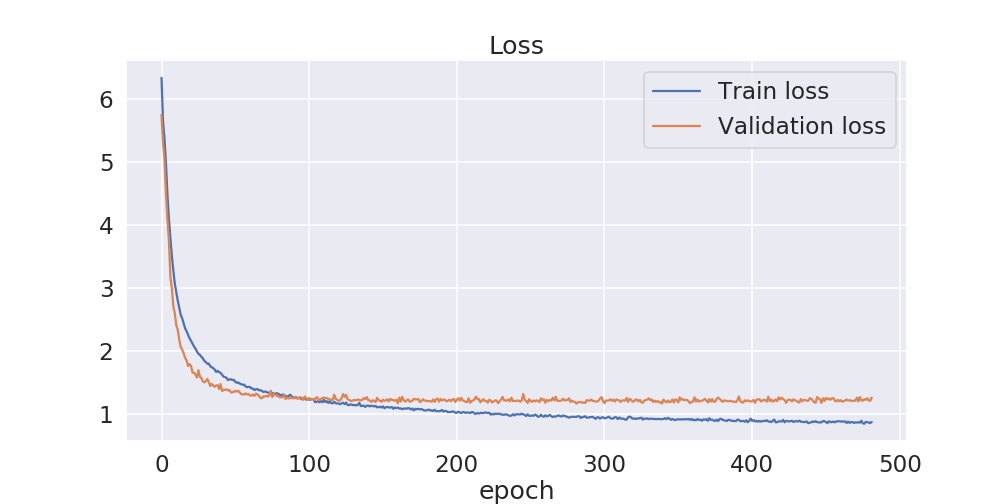

In [118]:
#Plotting loss curve
plt.figure(figsize=(14, 7))
plt.plot(cnn_history.history['loss'][:], label = 'Train loss')
plt.plot(cnn_history.history['val_loss'][:], label = 'Validation loss')

plt.legend()
plt.xlabel('epoch')
plt.title('Loss');

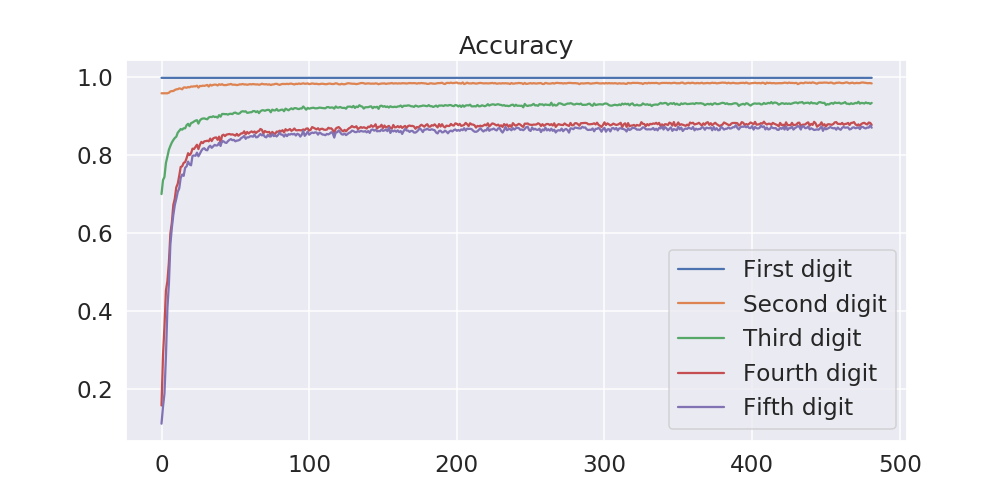

In [119]:
#Plotting accuracy
plt.figure(figsize=(14, 7))

plt.plot(cnn_history.history['val_dense_2_acc'][:], label = 'First digit')
plt.plot(cnn_history.history['val_dense_3_acc'][:], label = 'Second digit')
plt.plot(cnn_history.history['val_dense_4_acc'][:], label = 'Third digit')
plt.plot(cnn_history.history['val_dense_5_acc'][:], label = 'Fourth digit')
plt.plot(cnn_history.history['val_dense_6_acc'][:], label = 'Fifth digit')

plt.legend()
plt.title('Accuracy');

In [121]:
avg_accuracy = sum([cnn_scores[i] for i in range(6, 11)])/5
print("CNN Model. Average Accuracy for single digit: %.2f%%" % (avg_accuracy*100))

len_1_accuracy = np.prod(cnn_scores[10])
print("CNN Model. Accuracy for 1 digit sequence: %.2f%%" % (len_1_accuracy*100))

len_2_accuracy = np.prod(cnn_scores[9:11])
print("CNN Model. Accuracy for 2 digits sequence: %.2f%%" % (len_2_accuracy*100))

len_3_accuracy = np.prod(cnn_scores[8:11])
print("CNN Model. Accuracy for 3 digits sequence: %.2f%%" % (len_3_accuracy*100))

len_4_accuracy = np.prod(cnn_scores[7:11])
print("CNN Model. Accuracy for 4 digits sequence: %.2f%%" % (len_4_accuracy*100))

total_accuracy = np.prod([cnn_scores[6:11]])
print("CNN Model. Accuracy for 5 digits sequence: %.2f%%" % (total_accuracy*100))

CNN Model. Average Accuracy for single digit: 93.01%
CNN Model. Accuracy for 1 digit sequence: 86.55%
CNN Model. Accuracy for 2 digits sequence: 75.80%
CNN Model. Accuracy for 3 digits sequence: 70.00%
CNN Model. Accuracy for 4 digits sequence: 69.00%
CNN Model. Accuracy for 5 digits sequence: 69.00%


# 6. Text recognizer: Ready to predict new images <a class="anchor" id="second-sixth-bullet"></a>

In [ ]:
#define the Recognizer class
class Recognizer():
    def __init__(self):
        self.model = cnn_model()
    
    def predict(self, img_file, model_path):
        self.model.load_weights(model_path)
        img = imread(img_file)
        img = rgb2gray(img)
        img = resize(img, (32,32))
        img = img.reshape(-1, 32, 32, 1)
        pred = self.model.predict(img)
        text = self.decode_text(pred)
        return text
      
    def decode_text(self,res_vec, num_digits=5, num_classes=11, dummy_class=10):
        actual_digits = np.concatenate([np.argmax(res_vec[i],1) for i in range(num_digits)])
        res = actual_digits[actual_digits!=dummy_class]
        return ''.join(map(str, res))


Actual digits are:  1425-> Predicted digits are:  1425
Actual digits are:  14-> Predicted digits are:  14
Actual digits are:  10-> Predicted digits are:  10
Actual digits are:  26-> Predicted digits are:  26
Actual digits are:  328-> Predicted digits are:  323
Actual digits are:  53-> Predicted digits are:  53
Actual digits are:  36-> Predicted digits are:  2
Actual digits are:  21-> Predicted digits are:  21
Actual digits are:  51-> Predicted digits are:  51
Actual digits are:  30-> Predicted digits are:  30


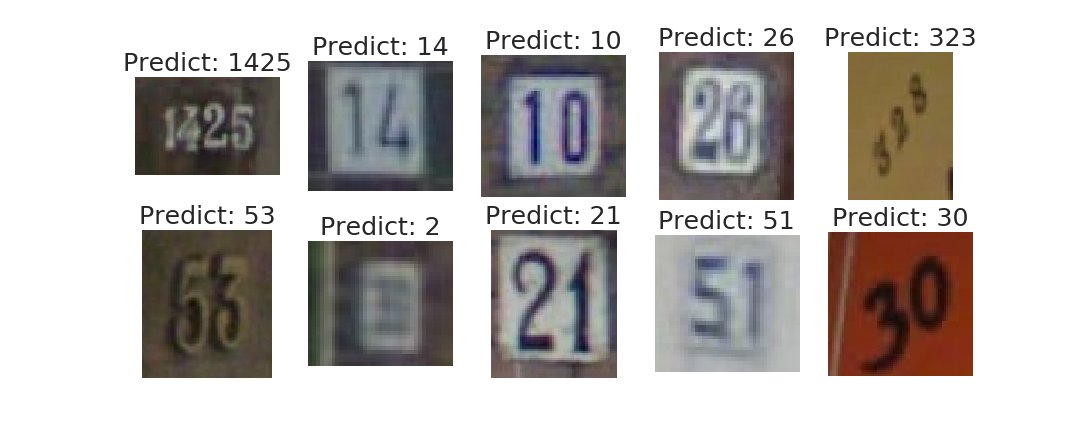

In [128]:
#test
@jit
def main():
    #initialization
    model_path = '/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/models/weights_best_cnn.hdf5'    
    data_path = "/content/drive/My Drive/Colab Notebooks/SimbeRobotics-data/ocr_dataset/"
    img_files = get_img_list(data_path)
    n_cols, n_rows = 5, 2
    test_img_index = np.random.choice(range(len(img_files)), size = n_cols*n_rows)
    plt.figure(figsize = (3*n_cols,3*n_rows))
    ocr = Recognizer()
    
    #get results and plot
    for n,i in enumerate(test_img_index):
        res = ocr.predict(join(data_path,img_files[i]), model_path)
        print('Actual digits are: ', img_files[i].split('_')[-1].split('.')[0], end='-> ')
        print('Predicted digits are: ', res)
        #plot
        plt.subplot(n_rows,n_cols,n+1)
        plt.axis('off')
        plt.imshow(imread(join(data_path,img_files[i]))) #or .resize(32,32)
        plt.title('Predict: '+res)
    plt.show()

main()

# Recommendations for future work <a class="anchor" id="third-bullet"></a>
* Data augmentation. Since there are 5567 tesing images not used for training, we could use data augmentation on the training set to significantly increase the diversity of data and avoid overfitting.
* Progressive resizing. This technique can improve the ability of the model to learn “scale-dependent” patterns. 
* Attention LSTM. Here we didn't try to use LSTM sequential model because of the amount of data synthesis/augmentation work.